# Electricity and Production Forecast

Data:
time series of Open Power System Data ([OPSD](https://open-power-system-data.org/)) for Germany. The data set includes daily electricity consumption, wind power production, and solar power production between 2006 and 2017. 
```
- Date — The date (yyyy-mm-dd format)
- Consumption — Electricity consumption in GWh
- Wind — Wind power production in GWh
- Solar — Solar power production in GWh
- Wind+Solar — Sum of wind and solar power production in GWh
```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime as dt
from dateutils import relativedelta
from fbprophet import Prophet

<h1> EDA

<h2> Load the data

In [3]:
df = pd.read_csv('opsd_germany_daily.csv', index_col=0)
df.head(10)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN
2006-01-06,1403.427,NaN,NaN,NaN
2006-01-07,1300.287,NaN,NaN,NaN
2006-01-08,1207.985,NaN,NaN,NaN
2006-01-09,1529.323,NaN,NaN,NaN


In [4]:
df.index = pd.to_datetime(df.index)

<h2> Deal with missing values

In [5]:
df_wind = pd.DataFrame(df['Wind'].dropna()).reset_index().rename(columns={'Date': 'ds', 'Wind': 'y'})
df_solar = pd.DataFrame(df['Solar'].dropna()).reset_index().rename(columns={'Date': 'ds', 'Solar': 'y'})
df_cons = pd.DataFrame(df['Consumption'].dropna()).reset_index().rename(columns={'Date': 'ds', 'Consumption': 'y'})

In [6]:
df_wind.shape, df_solar.shape, df_cons.shape, 

((2920, 2), (2188, 2), (4383, 2))

<h2> Automatic Decomposition

Q7 - Does the automatic decomposition of `statsmodels` identify anything else ?

In [7]:
s_wind = df_wind["y"]
s_solar = df_solar["y"]
s_cons = df_cons["y"]

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_wind = seasonal_decompose(s_wind, freq=365, extrapolate_trend='freq')
decomposition_solar = seasonal_decompose(s_solar, freq=365, extrapolate_trend='freq')
decomposition_cons = seasonal_decompose(s_cons, freq=365, extrapolate_trend='freq')

We set the frequency to 365 in this case since we observe a recurrent pattern over 365 days.

<Figure size 864x576 with 0 Axes>

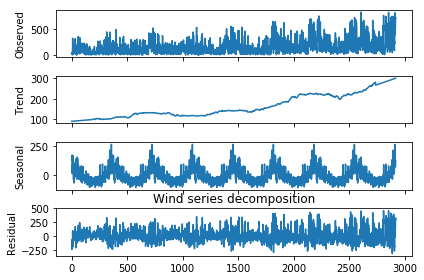

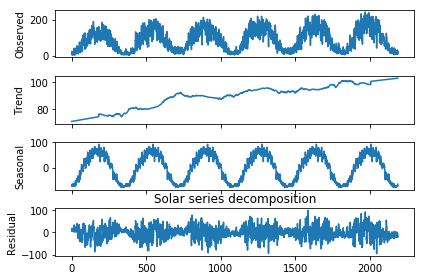

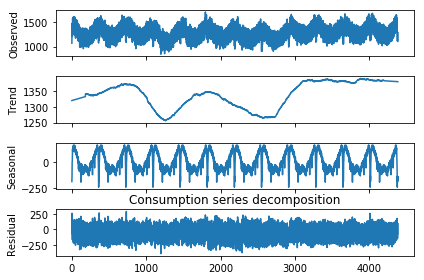

In [9]:
plt.figure(figsize=(12,8))

decomposition_wind.plot()
plt.title("Wind series decomposition")

decomposition_solar.plot()
plt.title("Solar series decomposition")

decomposition_cons.plot()
plt.title("Consumption series decomposition")
plt.show()

It is important to fit our Prophet model with historical data having a stable trend:

- Wind serie: trend look stable after index 2400
- Solar serie: trend look globaly stable
- Consumption serie: trend look stable after index 3200

In [10]:
df_wind_sel = df_wind[-1000:]
df_solar_sel = df_solar[-1000:]
df_cons_sel = df_cons[-1000:]

In [11]:
df_wind_sel[::-1].head(n=10)

,ds,y
2919,2017-12-31,721.176
2918,2017-12-30,721.247
2917,2017-12-29,584.277
2916,2017-12-28,506.424
2915,2017-12-27,394.507
2914,2017-12-26,717.453
2913,2017-12-25,587.810
2912,2017-12-24,812.422
2911,2017-12-23,748.074
2910,2017-12-22,228.773


<h1> Prophet model

In [12]:
model = Prophet(interval_width=0.95)
model.fit(df_wind_sel)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
forecast = model.make_future_dataframe(periods=90, freq='D', include_history=True)
forecast = model.predict(forecast)

In [14]:
forecast.shape

(1090, 19)

In [15]:
forecast[::-1].head(n=10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1089,2018-03-31,347.465077,12.697042,615.316540,345.104917,349.640521,-20.638390,-20.638390,-20.638390,3.194984,3.194984,3.194984,-23.833374,-23.833374,-23.833374,0.0,0.0,0.0,326.826687
1088,2018-03-30,347.206265,15.566257,586.810415,344.898933,349.335444,-38.261391,-38.261391,-38.261391,-14.706487,-14.706487,-14.706487,-23.554904,-23.554904,-23.554904,0.0,0.0,0.0,308.944874
1087,2018-03-29,346.947453,22.556971,632.070914,344.692949,349.040379,-21.984393,-21.984393,-21.984393,0.895750,0.895750,0.895750,-22.880143,-22.880143,-22.880143,0.0,0.0,0.0,324.963061
1086,2018-03-28,346.688642,48.327051,605.755729,344.486965,348.735885,-6.820133,-6.820133,-6.820133,14.988734,14.988734,14.988734,-21.808867,-21.808867,-21.808867,0.0,0.0,0.0,339.868509
1085,2018-03-27,346.429830,33.036623,621.144519,344.280213,348.417931,-20.365410,-20.365410,-20.365410,-0.015979,-0.015979,-0.015979,-20.349431,-20.349431,-20.349431,0.0,0.0,0.0,326.064420
1084,2018-03-26,346.171019,41.155334,624.279894,344.073180,348.131822,-30.759178,-30.759178,-30.759178,-12.240948,-12.240948,-12.240948,-18.518230,-18.518230,-18.518230,0.0,0.0,0.0,315.411841
1083,2018-03-25,345.912207,24.555633,624.878792,343.847200,347.846937,-8.454960,-8.454960,-8.454960,7.883945,7.883945,7.883945,-16.338905,-16.338905,-16.338905,0.0,0.0,0.0,337.457248
1082,2018-03-24,345.653396,34.312844,621.265892,343.628715,347.561657,-10.646344,-10.646344,-10.646344,3.194984,3.194984,3.194984,-13.841328,-13.841328,-13.841328,0.0,0.0,0.0,335.007051
1081,2018-03-23,345.394584,10.908327,611.263865,343.406462,347.248227,-25.766878,-25.766878,-25.766878,-14.706487,-14.706487,-14.706487,-11.060391,-11.060391,-11.060391,0.0,0.0,0.0,319.627707
1080,2018-03-22,345.135773,21.107937,611.462403,343.182101,346.931528,-7.138893,-7.138893,-7.138893,0.895750,0.895750,0.895750,-8.034643,-8.034643,-8.034643,0.0,0.0,0.0,337.996879


Text(0.5,1,'Consumption Forecast')

<Figure size 1296x432 with 0 Axes>

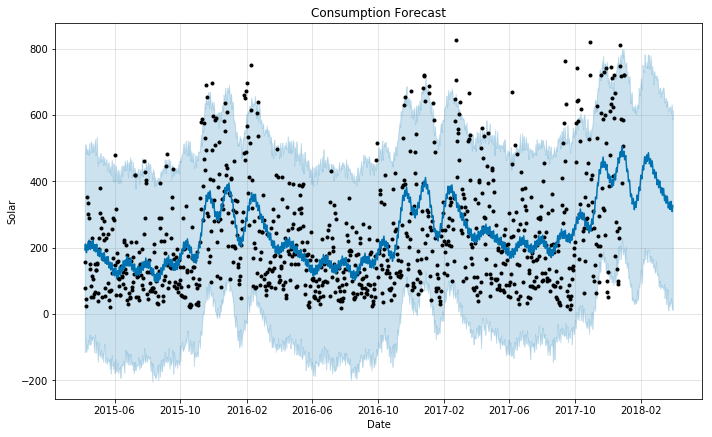

In [16]:
plt.figure(figsize=(18, 6))
model.plot(forecast, xlabel = 'Date', ylabel = 'Solar')
plt.title('Consumption Forecast')

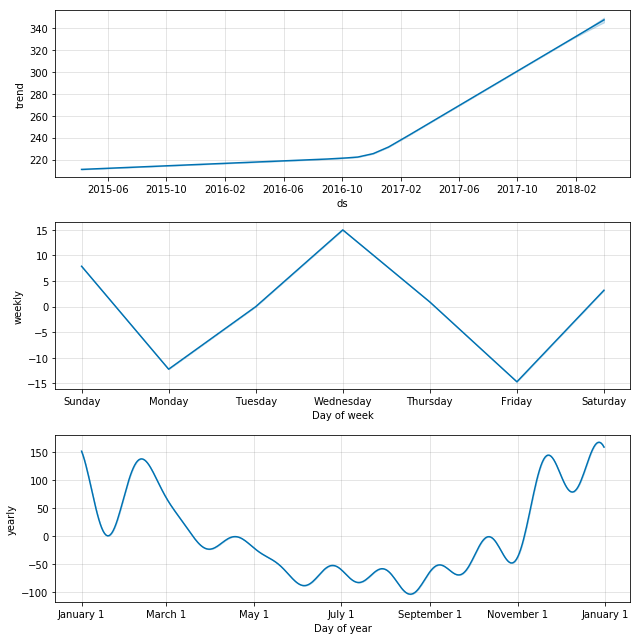

In [17]:
model.plot_components(forecast);

<h1> Prophet Forecasting

In [23]:
end_date = df.index[-1]
starting_date = end_date - relativedelta(years=3)
periods = 180

In [59]:
def prophecie(df, periods):
    model = Prophet(interval_width=0.8, daily_seasonality=True)
    model.fit(df)
    forecast = model.make_future_dataframe(periods=periods, freq='D', include_history=True)
    forecast = model.predict(forecast)
    return model, forecast

In [60]:
m_wind, f_wind = prophecie(df_wind_sel, periods)
m_solar, f_solar = prophecie(df_solar_sel, periods)
m_cons, f_cons = prophecie(df_cons_sel, periods)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<h2> Wind analysis

Text(0.5,1,'Wind Forecast')

<Figure size 1296x432 with 0 Axes>

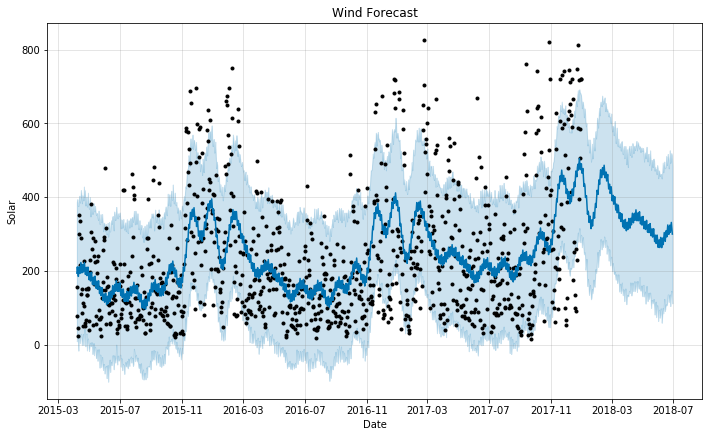

In [61]:
plt.figure(figsize=(18, 6))
m_wind.plot(f_wind, xlabel = 'Date', ylabel = 'Solar')
plt.title('Wind Forecast')

Production value can not be negative

In [62]:
f_wind["yhat_lower"][f_wind["yhat_lower"] < 0] = 0

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



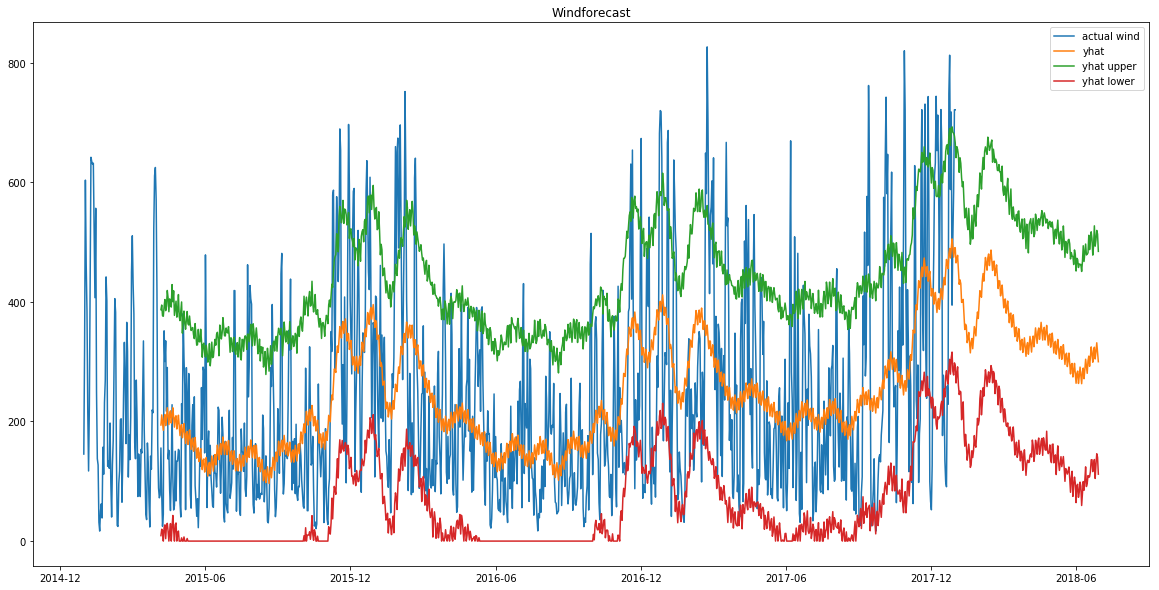

In [63]:
plt.figure(figsize=(20,10))
plt.plot(df["Wind"].loc[starting_date:], label="actual wind")
plt.plot(f_wind["ds"], f_wind["yhat"], label="yhat")
plt.plot(f_wind["ds"], f_wind["yhat_upper"], label="yhat upper")
plt.plot(f_wind["ds"], f_wind["yhat_lower"], label="yhat lower")
plt.legend()
plt.title("Windforecast")
plt.show()

<h2> Solar Analysis

Text(0.5,1,'Solar Forecast')

<Figure size 1296x432 with 0 Axes>

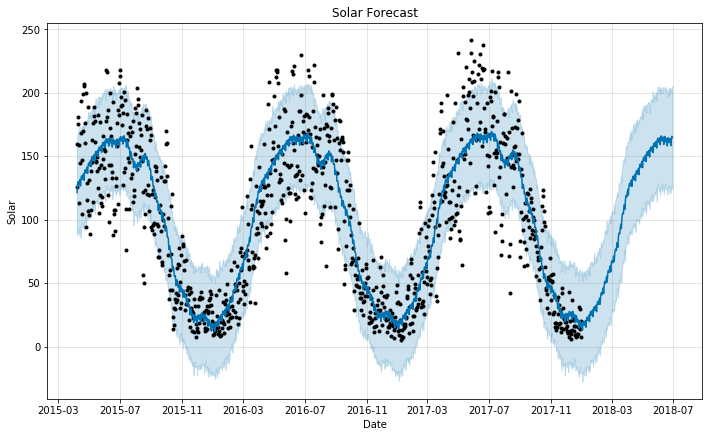

In [64]:
plt.figure(figsize=(18, 6))
m_solar.plot(f_solar, xlabel = 'Date', ylabel = 'Solar')
plt.title('Solar Forecast')

Solar production can not be negative

In [65]:
f_solar["yhat_lower"][f_solar["yhat_lower"] < 0] = 0

/home/zyncus/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



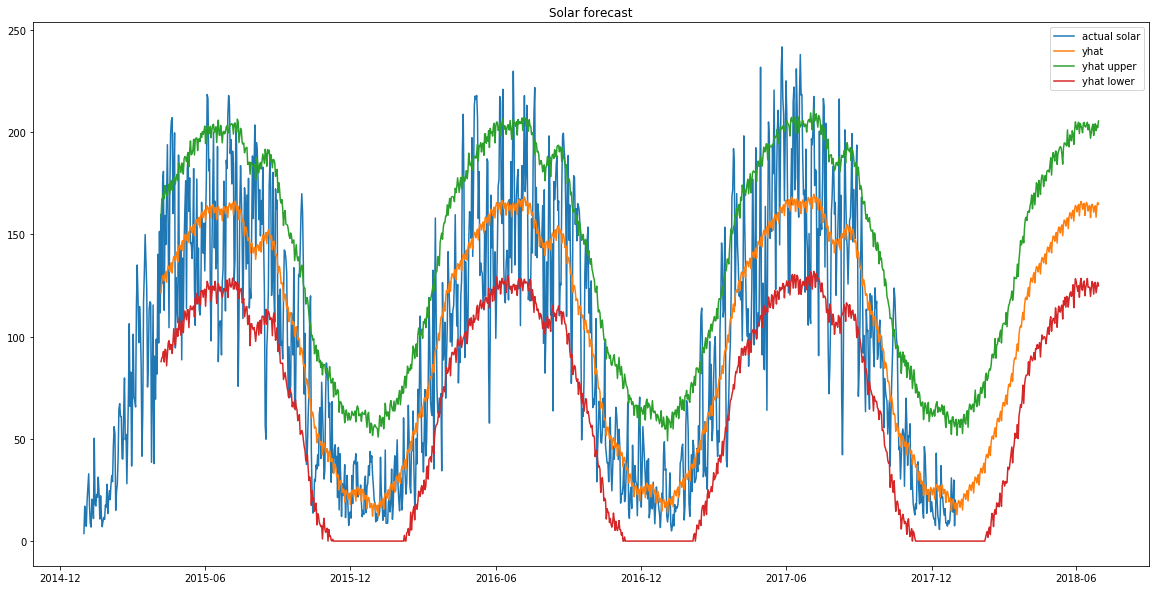

In [66]:
plt.figure(figsize=(20,10))
plt.plot(df["Solar"].loc[starting_date:], label="actual solar")
plt.plot(f_solar["ds"], f_solar["yhat"], label="yhat")
plt.plot(f_solar["ds"], f_solar["yhat_upper"], label="yhat upper")
plt.plot(f_solar["ds"], f_solar["yhat_lower"], label="yhat lower")
plt.legend()
plt.title("Solar forecast")
plt.show()

<h2> Consumption Analysis

Text(0.5,1,'Consumption Forecast')

<Figure size 1440x720 with 0 Axes>

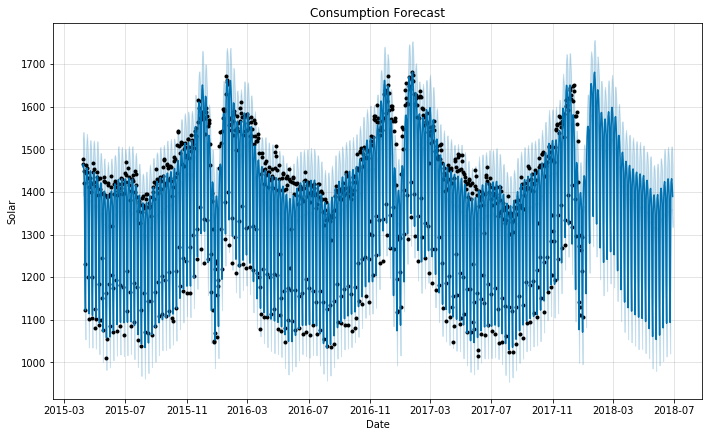

In [71]:
plt.figure(figsize=(20,10))
m_cons.plot(f_cons, xlabel = 'Date', ylabel = 'Solar')
plt.title('Consumption Forecast')

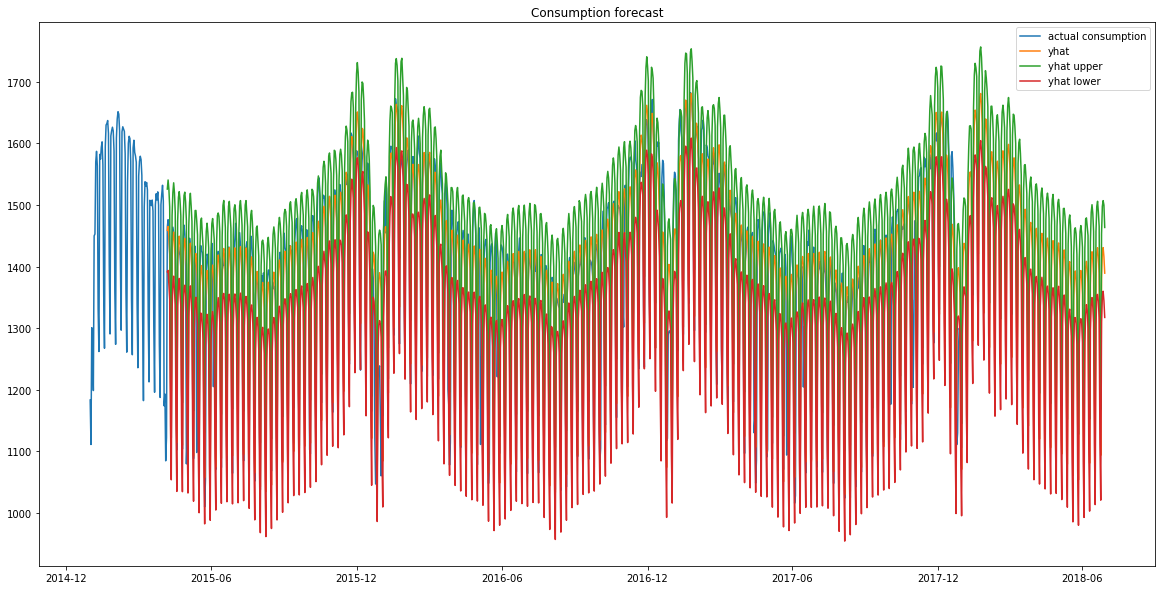

In [68]:
plt.figure(figsize=(20,10))
plt.plot(df["Consumption"].loc[starting_date:], label="actual consumption")
plt.plot(f_cons["ds"], f_cons["yhat"], label="yhat")
plt.plot(f_cons["ds"], f_cons["yhat_upper"], label="yhat upper")
plt.plot(f_cons["ds"], f_cons["yhat_lower"], label="yhat lower")
plt.legend()
plt.title("Consumption forecast")
plt.show()

<h2> Global plot

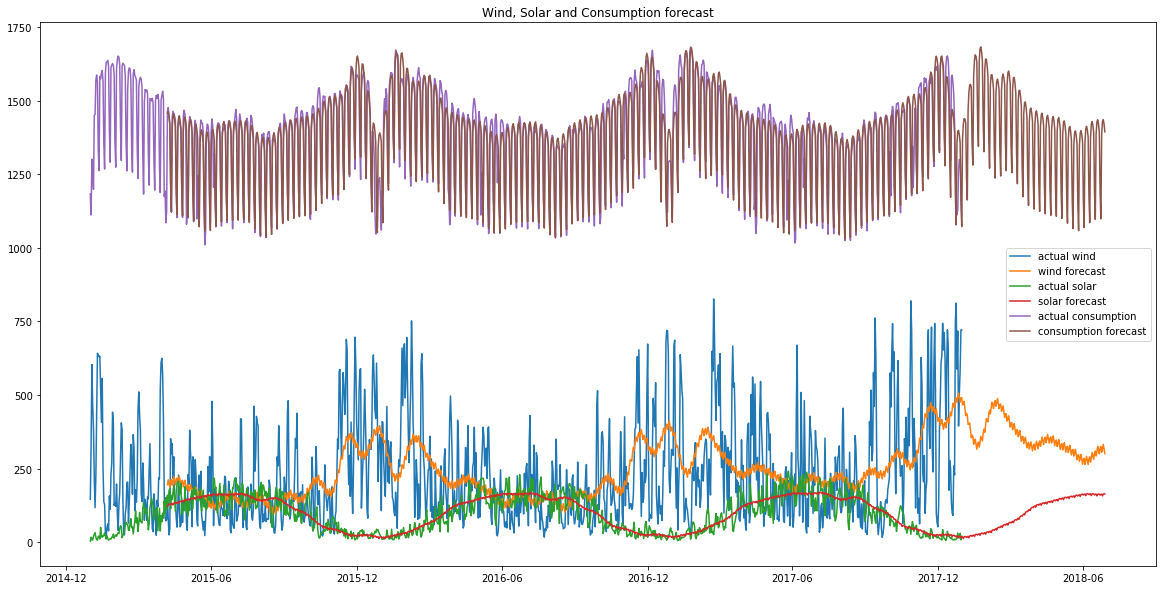

In [26]:
plt.figure(figsize=(20,10))
plt.plot(df["Wind"].loc[starting_date:], label="actual wind")
plt.plot(f_wind["ds"], f_wind["yhat"], label="wind forecast")
plt.plot(df["Solar"].loc[starting_date:], label="actual solar")
plt.plot(f_solar["ds"], f_solar["yhat"], label="solar forecast")
plt.plot(df["Consumption"].loc[starting_date:], label="actual consumption")
plt.plot(f_cons["ds"], f_cons["yhat"], label="consumption forecast")
plt.legend()
plt.title("Wind, Solar and Consumption forecast")
plt.show()